In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

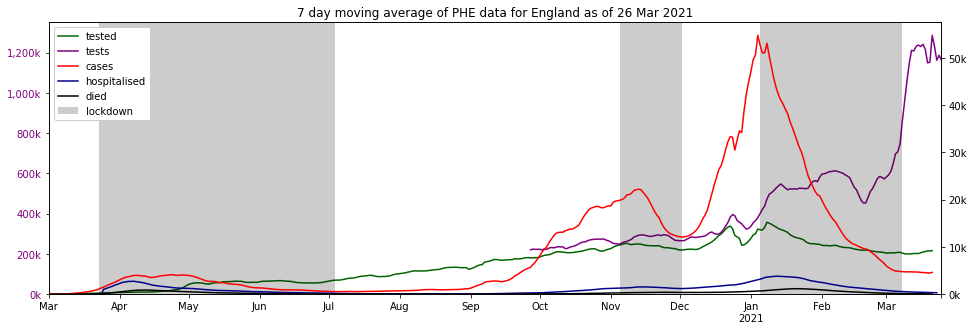

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

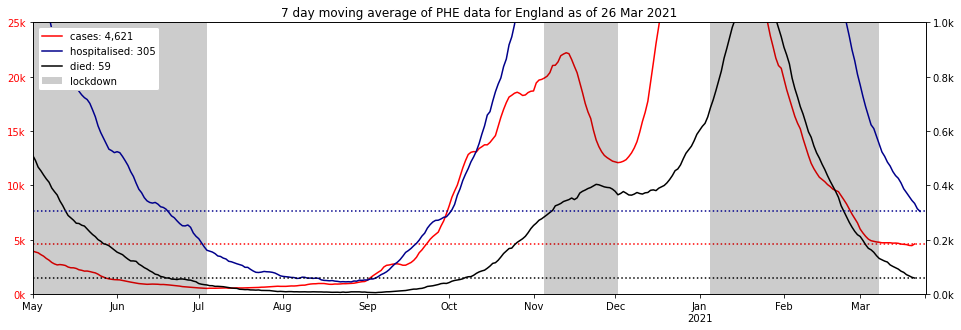

In [3]:
plot_summary(earliest_date='2020-05-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

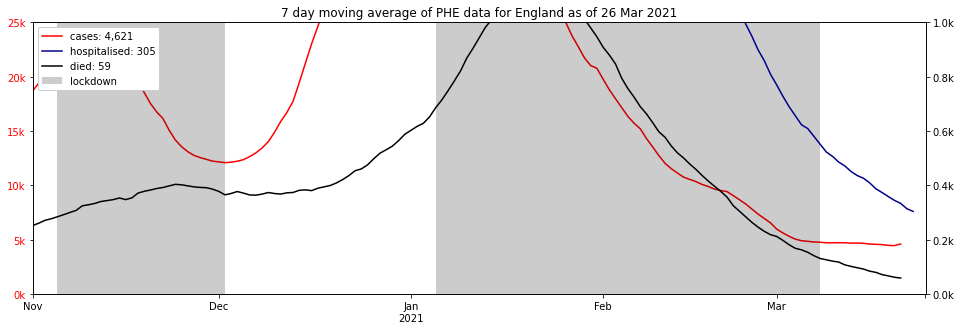

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,2226749.0,24940005.0,22713256.0,56286961,3.956065,40.352607,55.691328
1,Northern Ireland,N92000002,113637.0,711673.0,598036.0,1893667,6.000897,31.580843,62.418260
2,Scotland,S92000003,279814.0,2322832.0,2043018.0,5463300,5.121703,37.395311,57.482986
3,Wales,W92000004,389663.0,1341620.0,951957.0,3152879,12.358958,30.193261,57.447780


'partial: 29,316,130 (43.9%), full: 3,009,863'

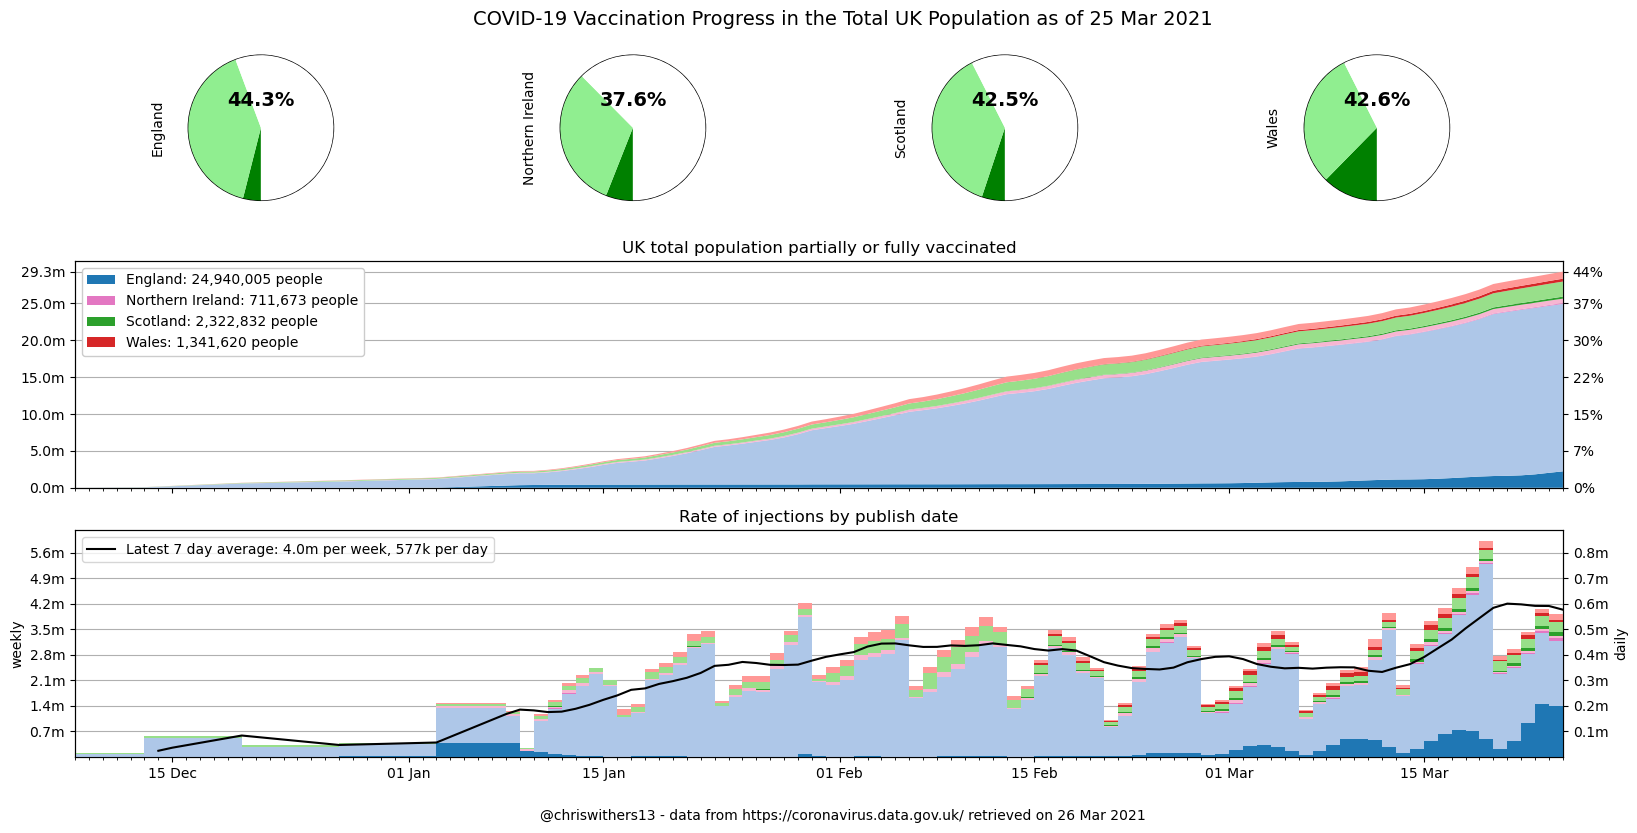

In [5]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [6]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,25 Mar 21,"+258,050","+198,206","+198,206","+24,940,005","+2,226,749","+2,226,749"
Northern Ireland,25 Mar 21,"+8,339","+8,730","+8,730","+711,673","+113,637","+113,637"
Scotland,25 Mar 21,"+37,121","+16,578","+16,578","+2,322,832","+279,814","+279,814"
Wales,25 Mar 21,"+21,432","+10,868","+10,868","+1,341,620","+389,663","+389,663"


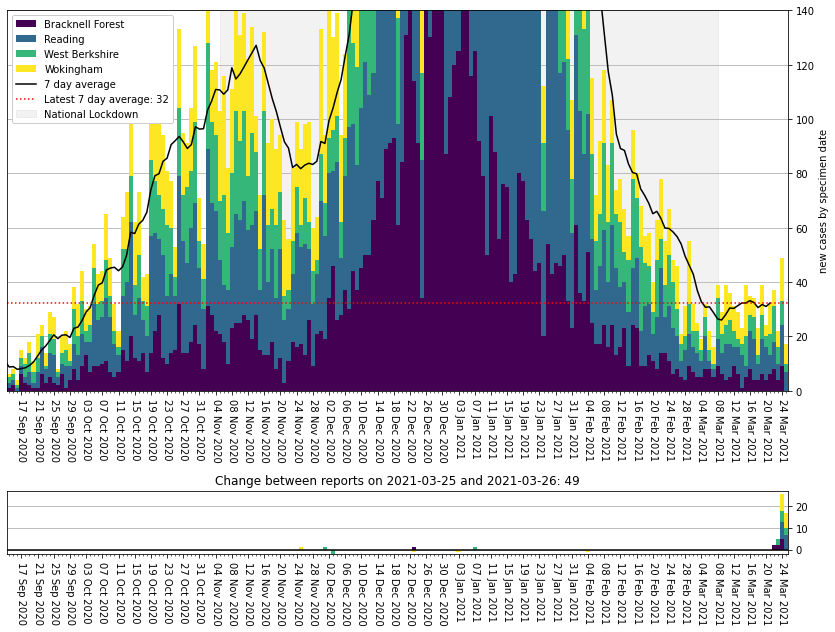

In [7]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

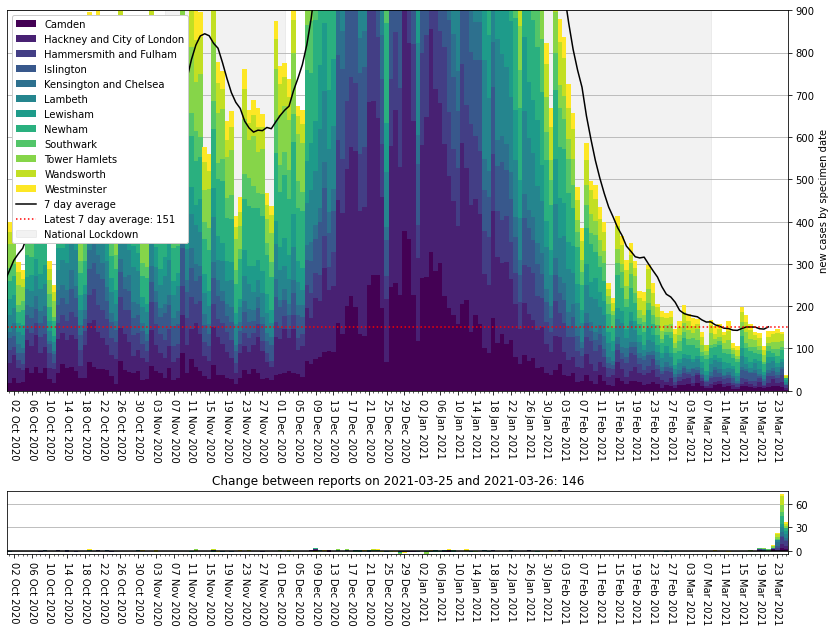

In [8]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [9]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [10]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,221.551414,160.0,2021-03-25
E08000018,Rotherham,154.477395,410.0,2021-03-25
E08000016,Barnsley,146.233179,361.0,2021-03-25
S12000040,West Lothian,144.729656,265.0,2021-03-25
E07000218,North Warwickshire,140.965923,92.0,2021-03-25
E06000013,North Lincolnshire,139.298400,240.0,2021-03-25
E08000032,Bradford,135.056023,729.0,2021-03-25
E08000036,Wakefield,128.907416,449.0,2021-03-25
E06000010,"Kingston upon Hull, City of",128.186375,333.0,2021-03-25


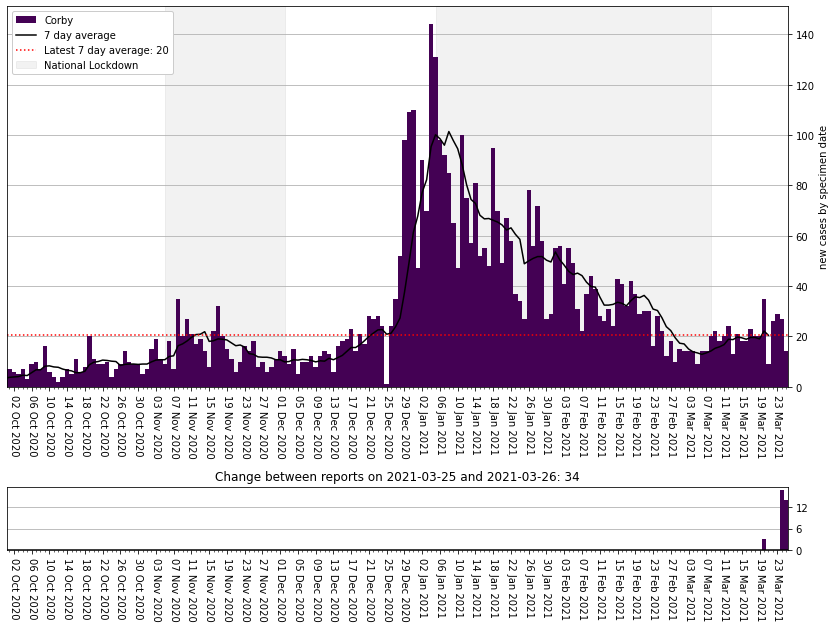

In [11]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [12]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,102.504101,813.0,2021-03-25
E08000025,Birmingham,64.721461,739.0,2021-03-25
E08000032,Bradford,135.056023,729.0,2021-03-25
E08000019,Sheffield,115.071650,673.0,2021-03-25
S12000049,Glasgow City,97.137983,615.0,2021-03-25
E08000003,Manchester,81.937857,453.0,2021-03-25
E08000036,Wakefield,128.907416,449.0,2021-03-25
E06000047,County Durham,83.004146,440.0,2021-03-25
S12000050,North Lanarkshire,126.548906,432.0,2021-03-25


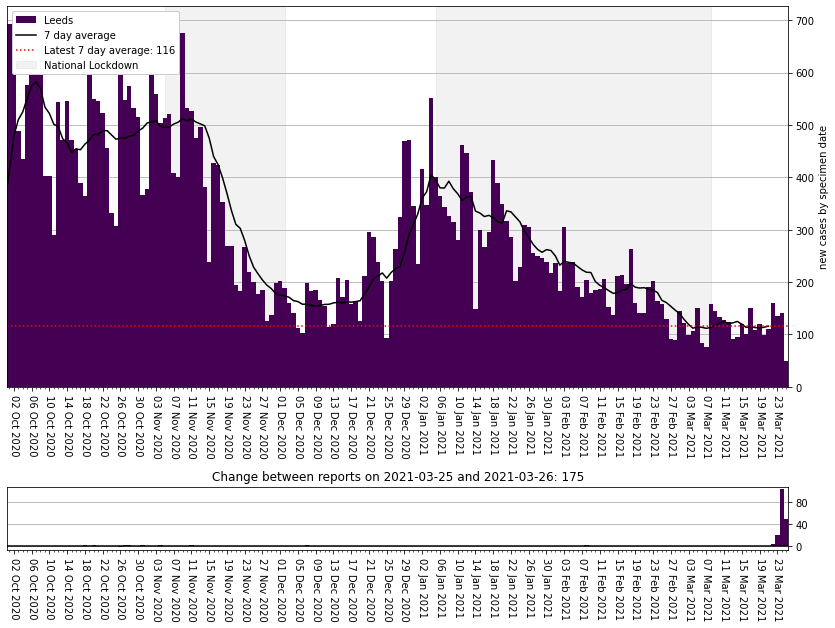

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

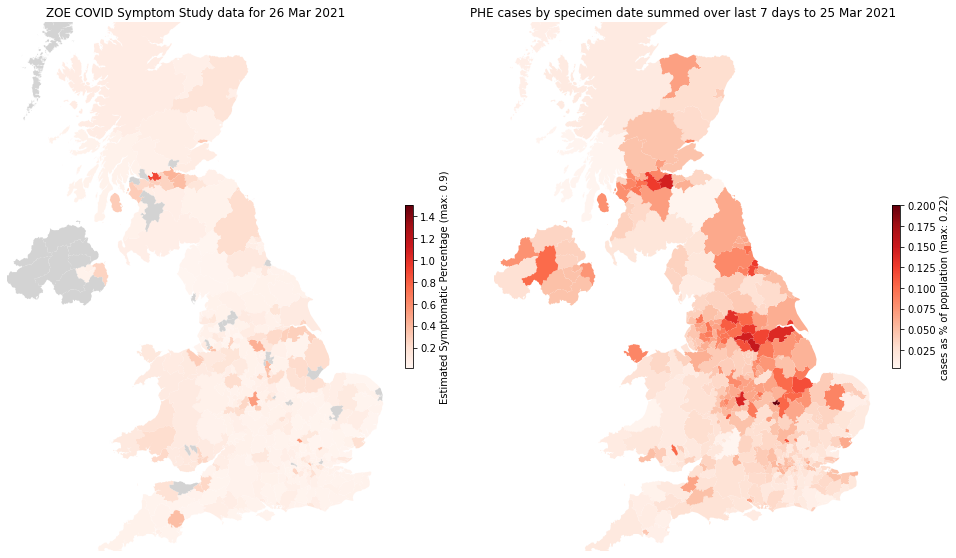

In [15]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [16]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

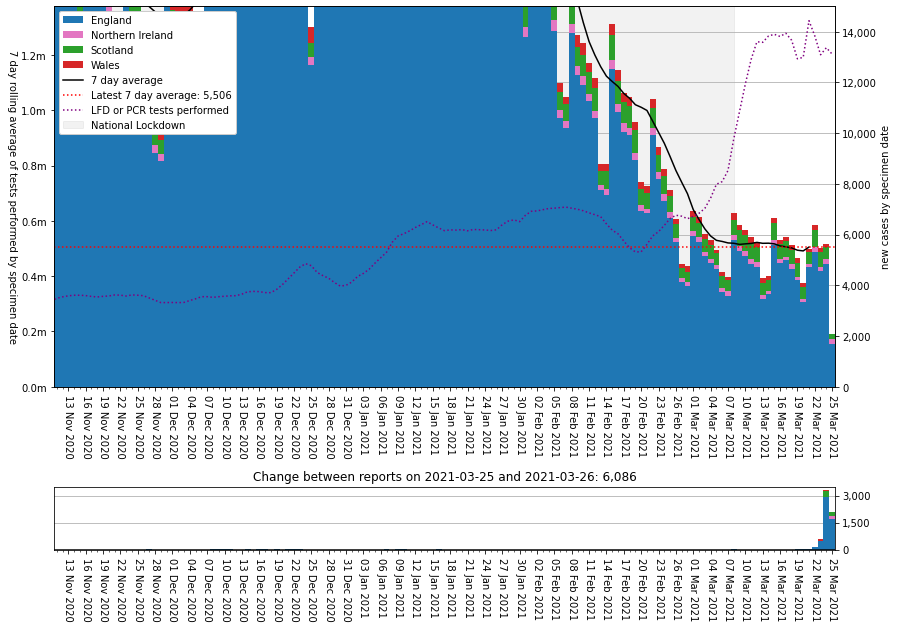

In [17]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')